# HD 155358
Two reasons to revisit -  
1) The original analysis didn't account for any mutual perturbations. If the planets are indeed in resonance, then resonant terms will be very dominant, and mutual perturbations can affect the dynamics, even on short timescales. The difference between a linear model and the N-body model could provide some insight into whether the system is in resonance!  
2) They performed 100,000 simulations assessing the longterm stability of the system. Can Machine Learning do as good a job with many fewer systems (e.g. 5,000)?

Plan:  
i) Simultaneously input to emcee i) WHFAST to generate radial velocity curves, ii) Gaussian process to model the stellar jitter (via George). Fit these to the available RV observations to get orbital parameters.  
ii) Perform a stability analysis using machine learning to see if you can match the detailed stability analysis of Robertson et al. (2012) where they performed over 100,000 (!) simulations.  

CHROMOSPHERIC ACTIVITY AND JITTER MEASUREMENTS FOR 2630 STARS ON THE CALIFORNIA PLANET SEARCH - This paper by Isaacson and Fisher have stellar jitter parameters measured for HD 155358, maybe just use those, or at least compare your jitter parameters to those?

Compare the semi-major amplitude derived from N-body compared to the linear combination of separate values to see the difference - http://exoplanetarchive.ipac.caltech.edu/docs/poet_calculations.html

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rebound
import emcee
import corner
%matplotlib inline

In [2]:
data = pd.read_csv("RV.txt", delimiter=' ')

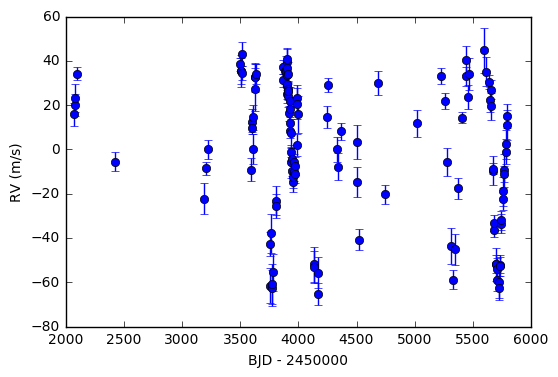

In [3]:
plt.errorbar(data["BJD"],data["RV"], yerr=data["Unc"], fmt='o')
plt.xlabel("BJD - 2450000")
plt.ylabel("RV (m/s)")

In [29]:
#Don't want to move to COM, want to see relative to the background. 
def fit_RV(times,theta):
    m1sini,m2sini,a1,a2,e1,e2,w1,w2,M1,M2,T1,T2,sini = theta
    AUyr2ms = 29682.77                   #AU/(yr/2pi) -> m/s
    dtoR = np.pi/180.                    #degrees to radians
    dtoyr2pi = 2*np.pi/365.              #days to yr/2pi
    mJ = 9.543e-4                        #Jupiter mass
    
    K = np.empty(0)    
    sim = rebound.Simulation()
    sim.integrator = "whfast"
    sim.add(m=0.92)                      #add the star
    sim.dt = 2*np.pi* a1**(1.5) / 50.    #dt = 50 steps per orb per of inner planet
    sim.add(m=m1sini*mJ/sini,e=e1,a=a1,omega=w1*dtoR,M=M1*dtoR)#,T=T1*dtoyr2pi) 
    sim.add(m=m2sini*mJ/sini,e=e2,a=a2,omega=w2*dtoR,M=M2*dtoR)#,T=T2*dtoyr2pi) 
    sim.move_to_com()
    for t in times*dtoyr2pi:
        sim.integrate(t)
        com = sim.calculate_com()
        vx = (sim.particles[0].vx - com.vx)*sini
        vy = (sim.particles[0].vy - com.vy)*sini
        vz = (sim.particles[0].vz - com.vz)*(1.-sini*sini)**0.5
        v = AUyr2ms*np.sqrt(vx**2 + vy**2 + vz**2)
        K = np.append(K,v)
    return K - (K.max() - K.min())/2.

In [30]:
t0 = data["BJD"].iloc[0]
times = data["BJD"] - t0                   #in Barycentric Julian Date (days)
m1sini,m2sini = 0.85,0.82                  #Jupiter masses
a1,a2 = 0.64,1.02                          #AU
e1,e2 = 0.17,0.16
w1,w2 = 143.,180.                          #in degrees
M1,M2 = 129.,233.                          #in degrees
T1,T2 = 1224.8-t0, 5345.4-t0               #Time of periastron passage, BJD

#observer angles - I dont think I need phi, since that just shifts w
sini = 1         #inclination angle

theta = m1sini,m2sini,a1,a2,e1,e2,w1,w2,M1,M2,T1,T2,sini

K = fit_RV(times,theta)

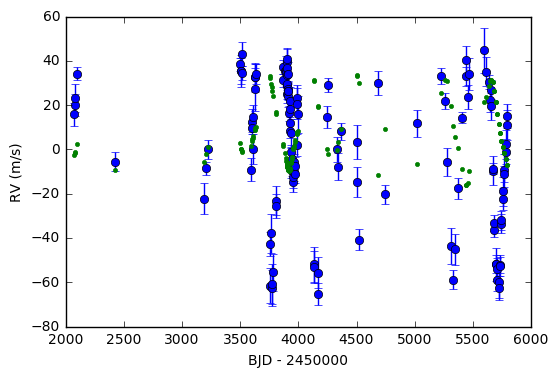

In [31]:
plt.errorbar(data["BJD"],data["RV"], yerr=data["Unc"], fmt='o')
plt.plot(data["BJD"],K, '.')
#times = np.linspace(data["BJD"].iloc[0],data["BJD"].iloc[-1],Np)
#plt.plot(times,K - K.mean())
plt.xlabel("BJD - 2450000")
plt.ylabel("RV (m/s)")

In [7]:
def lnlike(theta_j, times, y, yerr2):
    theta, jitter2 = theta_j[:-1], theta_j[-1]
    model = fit_RV(times,sini,theta)
    return -np.sum( 0.5*(y - model)**2/(yerr2 + jitter2) + np.log(yerr2 + jitter2) )

def lnprior(theta_j):
    m1sini,m2sini,a1,a2,e1,e2,w1,w2,M1,M2,sini,jitter2 = theta_j
    if 0.5<m1sini<2 and 0.5<m2sini<2 and 0.5<a1<1 and 0.75<a2<1.5 and 0<e1<0.5 and 0<e2<0.5 and 0<=w1<=2*np.pi and 0<=w2<=2*np.pi and 0<=M1<=2*np.pi and 0<=M2<=2*np.pi and 0<=sini<=1 and 0<jitter2<20:
        return 0   
    return -np.inf 

def lnprob(theta_j, times, y, yerr2):
    lp = lnprior(theta_j)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta_j, times, y, yerr2)

In [32]:
times = data["BJD"] - data["BJD"].iloc[0] #BJD (days)
m1sini,m2sini = 0.85,0.82                 #Jupiter masses
a1,a2 = 0.64,1.02                         #AU
e1,e2 = 0.17,0.16
w1,w2 = 143.,180.                         #in degrees
M1,M2 = 129.,233.                         #in degrees
jitter2 = 1                               #stellar jitter term squared (m^2/s^2)

#observer angles - I dont think I need phi, since that just shifts w
sini = 1           #inclination angle

theta_ini = [m1sini,m2sini,a1,a2,e1,e2,w1,w2,M1,M2,sini,jitter2]

Run the MCMC. **Warning** This could take a while.

In [9]:
ndim, nwalkers, n_it = 11, 500, 50000

pos = [theta_ini + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(times, data["RV"].values, (data["Unc"].values)**2));
sampler.run_mcmc(pos, n_it);

/Users/silburt/anaconda2/envs/ml/lib/python2.7/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/Users/silburt/anaconda2/envs/ml/lib/python2.7/site-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


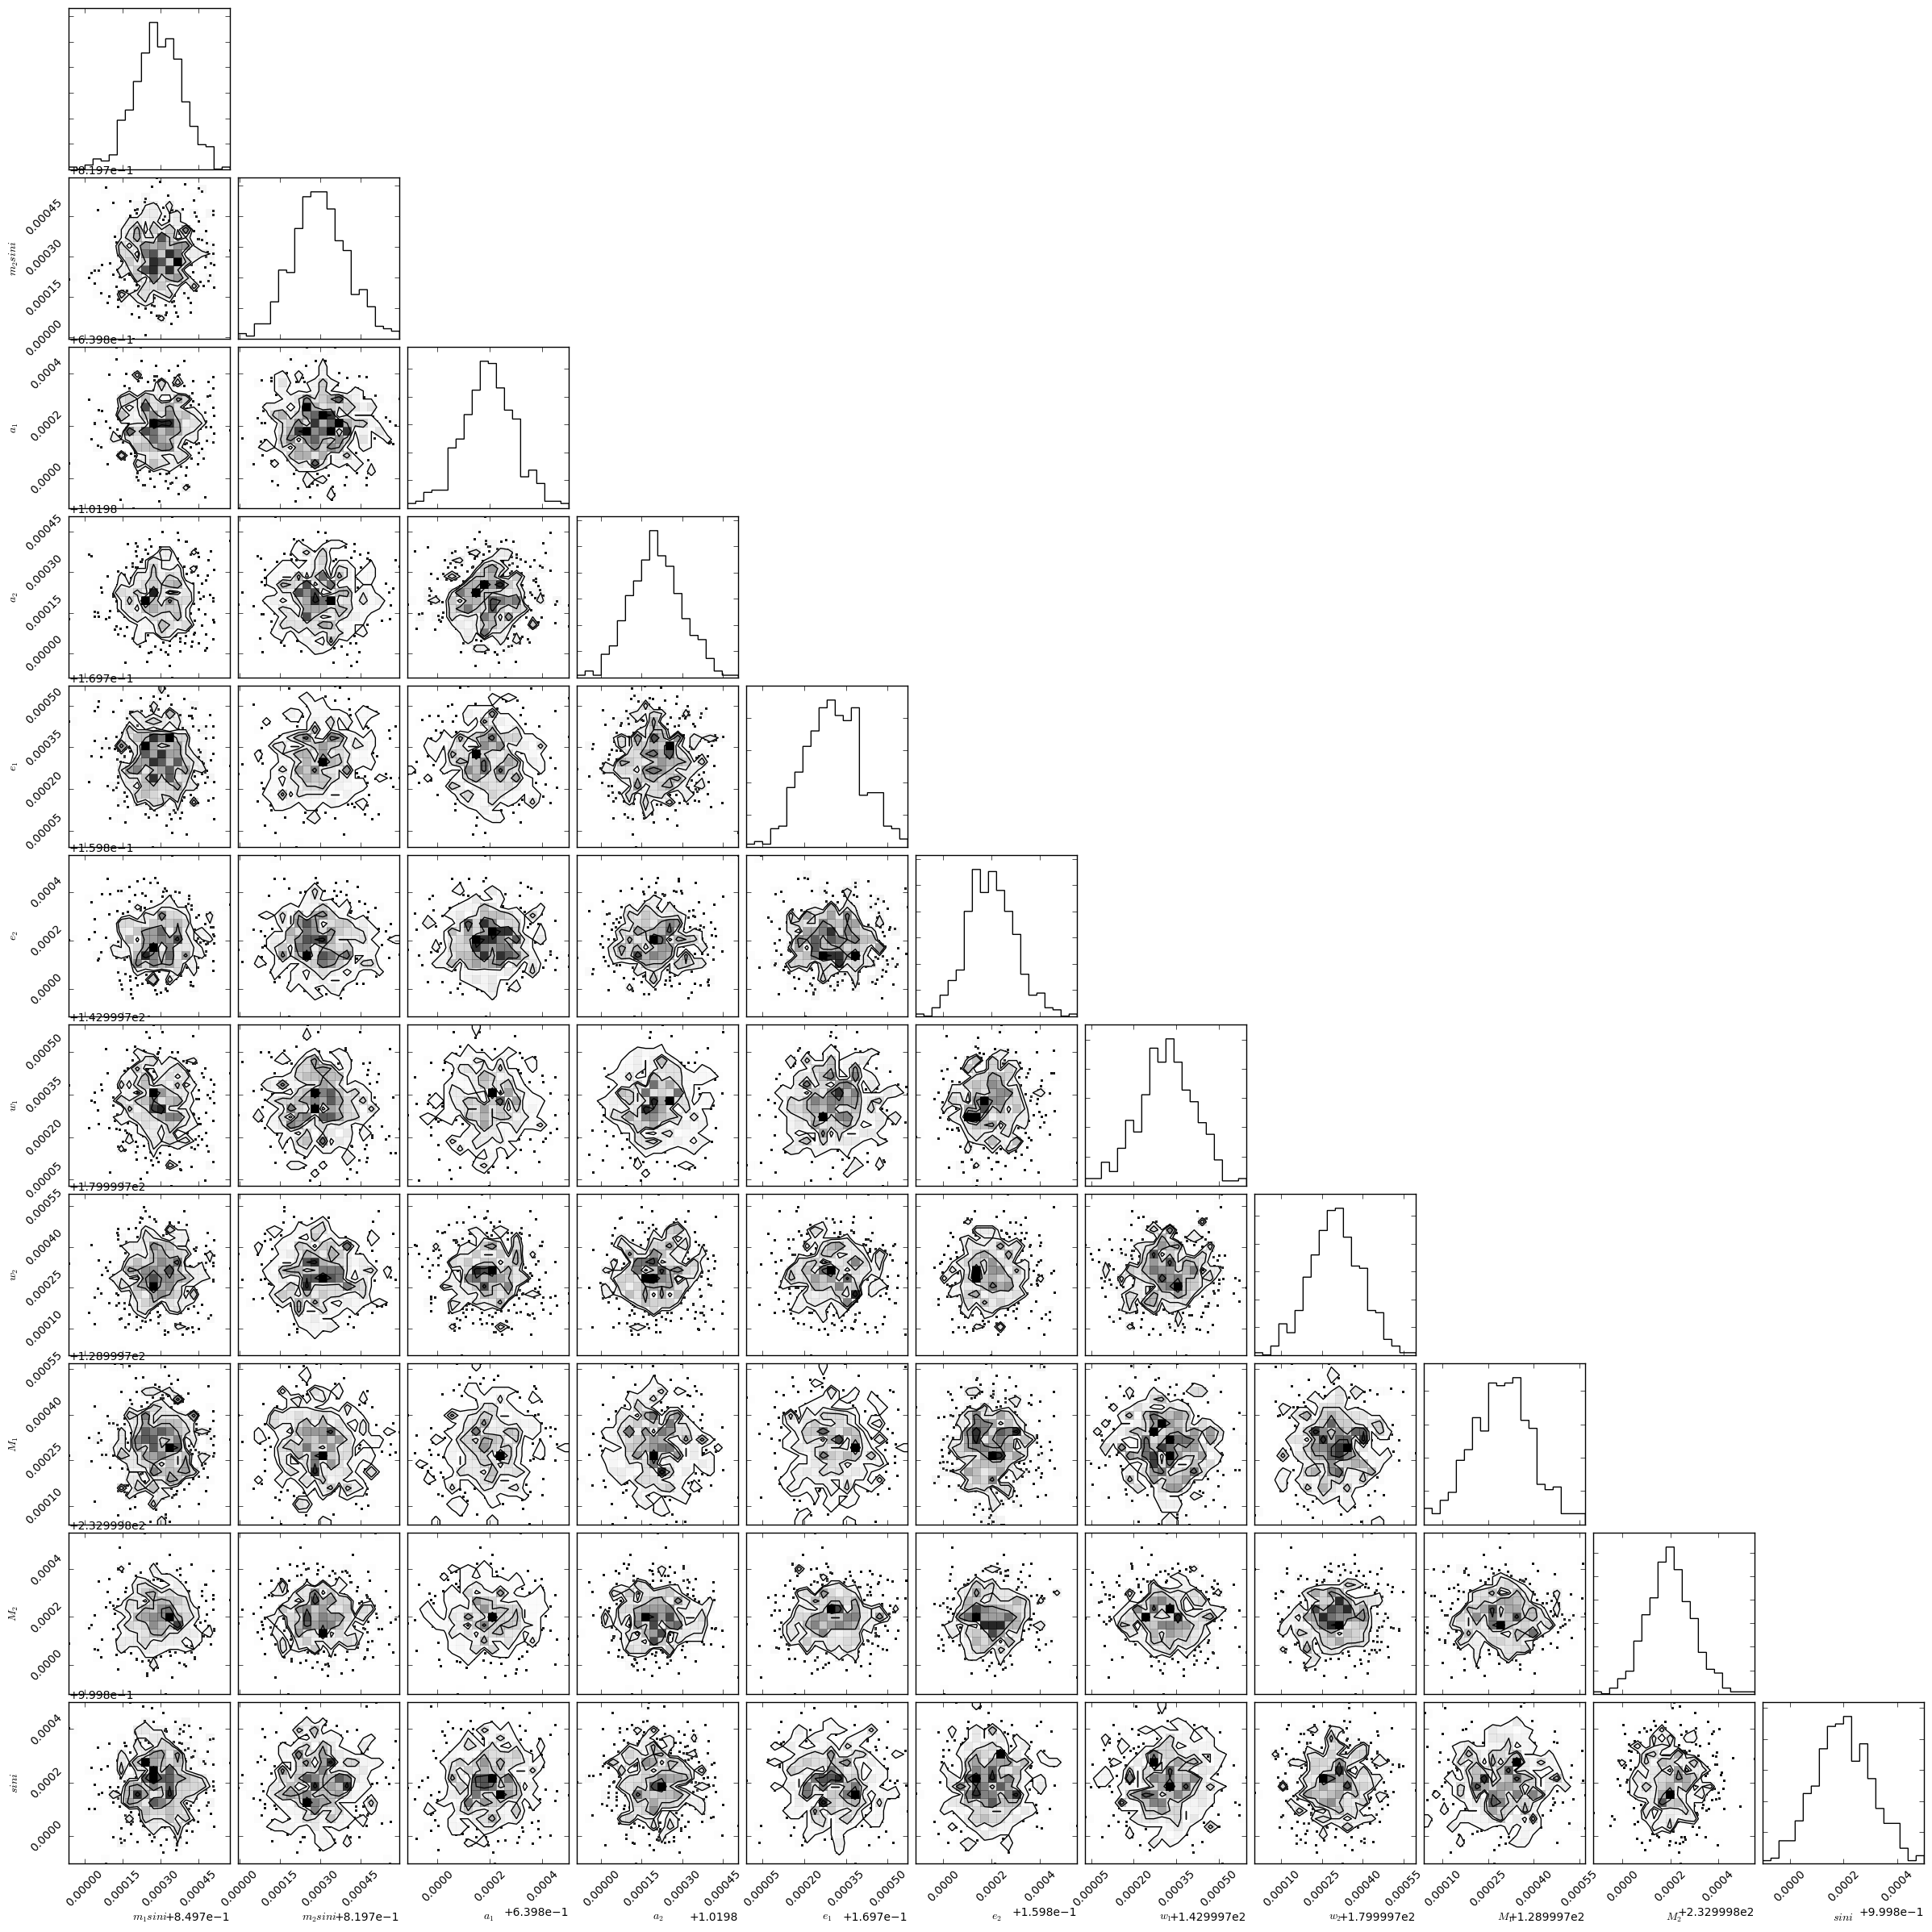

In [10]:
#Corner plot
burnin = 5000
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$m_1sini$","$m_2sini$","$a_1$","$a_2$","$e_1$","$e_2$","$w_1$","$w_2$","$M_1$","$M_2$","$sini$"])
fig.savefig("MCMC_corner.png")